### Задание

Пришло время проанализировать результаты эксперимента, который мы провели вместе с командой дата сайентистов. Эксперимент проходил с 2022-10-03 по 2022-10-09 включительно. Для эксперимента были задействованы 2 и 1 группы.

В группе 2 был использован один из новых алгоритмов рекомендации постов, группа 1 использовалась в качестве контроля. 


Основная гипотеза заключается в том, что новый алгоритм во 2-й группе приведет к увеличению CTR.

Ваша задача — проанализировать данные АB-теста. 

Выбрать метод анализа и сравнить CTR в двух группах (мы разбирали t-тест, Пуассоновский бутстреп, тест Манна-Уитни, t-тест на сглаженном ctr (α=5) а также t-тест и тест Манна-Уитни поверх бакетного преобразования).
Сравните данные этими тестами. А еще посмотрите на распределения глазами. Почему тесты сработали так как сработали? 
Опишите потенциальную ситуацию, когда такое изменение могло произойти. Тут нет идеального ответа, подумайте.
Напишите рекомендацию, будем ли мы раскатывать новый алгоритм на всех новых пользователей или все-таки не стоит.
Ваше решение — это ссылка на merge request с проведенным анализом.

In [1]:
# импорт библиотек
import pandas as pd
import numpy as np
import pandahouse
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
from tqdm.auto import tqdm
import warnings
warnings.filterwarnings("ignore")

# кастомизация графиков
custom_params = {"axes.spines.right": False, 
                 "axes.spines.top": False, 
                 'figure.figsize': (10, 4)}
sns.set_theme(style = "ticks", rc = custom_params)

In [2]:
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

In [3]:
# вытащим данные из БД
query = '''
select 
    min(time) as time_var,
    user_id, exp_group,
    countIf(action, action = 'like') as likes,
    countIf(action, action = 'view') as views,
    likes / views as ctr
from simulator_20221020.feed_actions
where toDate(time)  >= '2022-10-03' and toDate(time) <= '2022-10-09' 
                                and exp_group in (1, 2)
group by user_id, exp_group
order by time_var desc
'''

df = pandahouse.read_clickhouse(query, connection = connection)

In [4]:
df.head(3)

,time_var,user_id,exp_group,likes,views,ctr
0,2022-10-09 23:59:47,141164,2,0,1,0.0
1,2022-10-09 23:59:30,17749,2,0,1,0.0
2,2022-10-09 23:59:03,115129,2,0,3,0.0


In [5]:
df.shape

(20031, 6)

In [6]:
# посмотрим на распределение пользователей внутри групп
df.groupby('exp_group', as_index = False).agg({'user_id': 'count', 'ctr': 'mean'}) \
    .rename(columns = {'user_id': 'amount_of_users', 'ctr': 'average_ctr'})

,exp_group,amount_of_users,average_ctr
0,1,10079,0.215605
1,2,9952,0.214419


Средний CTR в тестовой группе даже меньше чем в контрольной. Посмотрим на распределения глазами:

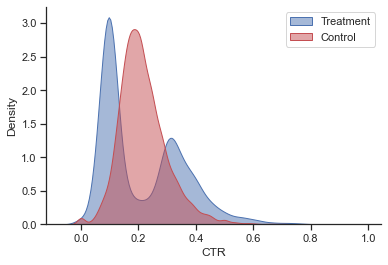

In [7]:
sns.kdeplot(data = df, x = 'ctr', hue = 'exp_group', 
             palette = ['r', 'b'], alpha = 0.5, fill = True)
plt.xlabel('CTR')
plt.legend(['Treatment', 'Control'])

Распределение CTR'ов в тестовой группе двугорбое, работать с таким сложнее. Отдельный вопрос, почему это могло произойти.

####  t-test и тест Мана-Уитни

In [8]:
# вытащим ctr'ры для контрольной и тестовой групп
treatmnet = df.query('exp_group == 2').ctr.values
control = df.query('exp_group == 1').ctr.values

In [9]:
st.ttest_ind(treatmnet, control, equal_var = False, alternative = 'two-sided')

Ttest_indResult(statistic=-0.7094392041270485, pvalue=0.4780623130874935)

In [10]:
st.mannwhitneyu(treatmnet, control, alternative = 'two-sided')

MannwhitneyuResult(statistic=43704947.5, pvalue=6.0376484617779035e-56)

In [11]:
print(f'''treatment CTR mean: {round(treatmnet.mean(), 3)}, 
treatment CTR standard deviation: {round(np.std(treatmnet), 3)}
---------------------------------------
control CTR mean {round(control.mean(), 3)}, 
control CTR standard deviation: {round(np.std(control), 3)}''')

treatment CTR mean: 0.214, 
treatment CTR standard deviation: 0.144
---------------------------------------
control CTR mean 0.216, 
control CTR standard deviation: 0.084


Т-тест и тест Мана-Уитни дают сильно разные результаты. По всей видимости, дело в том что т-тест проверяет гипотезу о равенстве средних, а средние различаются только в 3 знаке после запятой. В то же время, тест Мана-Уитни проверяет гипотезу о разнице распределений, а распределения отличаются сильно, это видно на гистограмме выше, отсюда такие результаты.

####  Сглаженный CTR

In [12]:
def test_above_smothed_ctr(treatment_likes, treatment_views, control_likes, control_views, hyperparameter = 5):
    
    '''
    Функция принимает на вход значения поюзерных лайков для тестовой и контрольной групп, а также значение гиперпараметра для сглаженного CTR, 
    и возвращает список с 2 элементами: значениями сглаженного CTR для тестовой и контрольной групп соответственно, и распечатывает гистограмму
    с распределением сглаженного CTR для обеих групп, а также данные о статистике и p-value для т-теста и теста Мана-Уитни
    '''
    
    # функция для подсчета сглаженного CTR
    def get_smothed_ctr(user_likes, user_views, global_ctr, alpha):
        smothed_ctr = (user_likes + alpha * global_ctr) / (user_views + alpha)
        return smothed_ctr
    
    # считаем общегрупповой CTR
    global_ctr_treatment = treatment_likes.sum() / treatment_views.sum()
    global_ctr_control = control_likes.sum() / control_views.sum()
    
    # применяем функцию и находим значения сглаженного CTR
    smothed_treatment_ctr = get_smothed_ctr(treatment_likes, treatment_views, global_ctr_treatment, hyperparameter)
    smothed_control_ctr = get_smothed_ctr(control_likes, control_views, global_ctr_control, hyperparameter)
    
    # проводим статистические тесты
    ttest_stat, ttest_pval = st.ttest_ind(smothed_treatment_ctr, smothed_control_ctr, equal_var = False, alternative = 'two-sided')
    mu_stat, mu_pval = st.mannwhitneyu(smothed_treatment_ctr, smothed_control_ctr, alternative = 'two-sided')
    
    # рисуем
    sns.kdeplot(smothed_treatment_ctr, fill = True)
    sns.kdeplot(smothed_control_ctr, fill = True)
    plt.title('Smothed CTR')
    plt.legend(['Treatment', 'Control'])
    plt.text(0.45, 5, f'''t-test: \nstatistic: {round(ttest_stat, 3)} \np-value: {round(ttest_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})
    plt.text(0.45, 2.5, f'''mann-whitney test: \nstatistic: {round(mu_stat, 3)} \np-value: {round(mu_pval, 3)}''', style = 'oblique',
            bbox = {'facecolor': 'purple', 'alpha': 0.1, 'pad': 10})
    
    return([smothed_treatment_ctr, smothed_control_ctr])

In [13]:
# вытащим поюзерные лайки и просмотры для тестовой и контрольной групп для запуска написанной функции
treatment_likes = df.query('exp_group == 2').likes.values
treatment_views = df.query('exp_group == 2').views.values
control_likes = df.query('exp_group == 1').likes.values
control_views = df.query('exp_group == 1').views.values

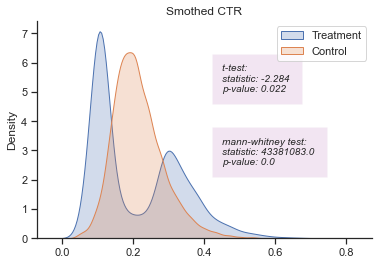

In [14]:
result = test_above_smothed_ctr(treatment_likes, treatment_views, control_likes, control_views, hyperparameter = 5)

In [15]:
print(f'''treatment smoothed CTR mean: {round(result[0].mean(), 3)}, 
treatment smoothed CTR standard deviation: {round(np.std(result[0]), 3)}
------------------------------------------------
control smoothed CTR mean {round(result[1].mean(), 3)}, 
control smoothed CTR standard deviation: {round(np.std(result[1]), 3)}''')

treatment smoothed CTR mean: 0.211, 
treatment smoothed CTR standard deviation: 0.125
------------------------------------------------
control smoothed CTR mean 0.214, 
control smoothed CTR standard deviation: 0.071


Тест Мана-Уитни на сглаженных CTR'ах по прежнему дает стат. значимые различия, поскольку распределения сглаженных CTR'ов все равно сильно различаются.А вот результаты т-теста изменились сильно: теперь мы имеем p-value < 0.05, то есть средние стат. значимо различаются. После сглаживания разница между средними увеличилась, а изменчивость данных снизилась, что и повлияло на т-тест.

####  Пуасоновский бутстреп

In [16]:
def bootstrap(likes1, views1, likes2, views2, n_bootstrap = 2000):

    '''
    Функция принимает на вход значения лайков и просмотров для тестовой и контрольной групп, а также количество итераций для подбора весов,
    и возвращает значения глабальных CTR'ов для тестовой и контрольной групп.
    '''
    
    # сгенерируем веса
    weights_1 = st.poisson(1).rvs(
        (n_bootstrap, len(likes1))).astype(np.int64)
    weights_2 = st.poisson(1).rvs(
            (n_bootstrap, len(likes2))).astype(np.int64)
    
    # взвесим и найдем глобальные CTR'ы
    globalCTR1 = (weights_1*likes1).sum(axis=1)/(weights_1*views1).sum(axis=1) 
    globalCTR2 = (weights_2*likes2).sum(axis=1)/(weights_2*views2).sum(axis=1)

    return globalCTR1, globalCTR2

In [17]:
# вытащим поюзерные лайки и просмотры для тестовой и контрольной групп для запуска написанной функции
likes2 = df[df.exp_group == 2].likes.to_numpy()
views2 = df[df.exp_group == 2].views.to_numpy()
likes1 = df[df.exp_group == 1].likes.to_numpy()
views1 = df[df.exp_group == 1].views.to_numpy()

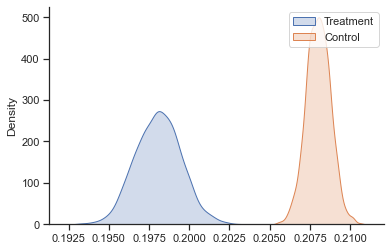

In [18]:
ctr1, ctr2 = bootstrap(likes1, views1, likes2, views2)

sns.kdeplot(ctr2, fill = True)
sns.kdeplot(ctr1, fill = True)
plt.legend(['Treatment', 'Control'])

<AxesSubplot:ylabel='Density'>

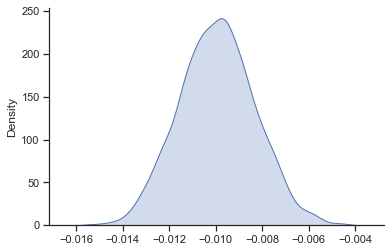

In [19]:
# разница между глобальными CTR
sns.kdeplot(ctr2 - ctr1, fill = True)

Распределение разниц глобальных CTR'ов не пересекает 0, а это значит что различия существуют.

Проверим тестами:

In [20]:
ttest_stat, ttest_pval = st.ttest_ind(ctr2, ctr1, equal_var = False, alternative = 'two-sided')
mu_stat, mu_pval = st.mannwhitneyu(ctr2, ctr1, alternative = 'two-sided')

print(f't-test: statistic {ttest_stat} p-value {ttest_pval} \nmann-whitney: statistic {mu_stat} p-value {mu_pval}')

t-test: statistic -275.78024844191225 p-value 0.0 
mann-whitney: statistic 0.0 p-value 0.0


Предсказуемо, тесты также показывают наличие стат. значимых различий.

####  Бакетное преобразование

In [22]:
query = '''

select 
    exp_group, bucket,
    sum(likes)/sum(views) as bucket_ctr
from
    (select 
        min(time) as time_var,
        user_id, exp_group,
        countIf(action, action = 'like') as likes,
        countIf(action, action = 'view') as views,
        likes / views as ctr,
        xxHash64(user_id)%50 as bucket
    from simulator_20221020.feed_actions
    where toDate(time)  >= '2022-10-03' and toDate(time) <= '2022-10-09' 
                                    and exp_group in (1, 2)
    group by user_id, exp_group
    order by time_var desc)
group by exp_group, bucket

'''

df = pandahouse.read_clickhouse(query, connection = connection)

In [23]:
# посмотрим на усредненные ctr'ы метапользователей
df.groupby('exp_group', as_index = False).agg({'bucket_ctr': np.mean})

,exp_group,bucket_ctr
0,1,0.208122
1,2,0.198259


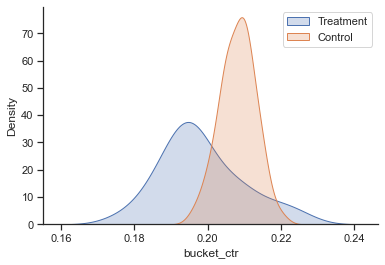

In [24]:
# посмотрим на распределения ctr'ов метапользователей
sns.kdeplot(df[df.exp_group == 2].bucket_ctr, shade = True)
sns.kdeplot(df[df.exp_group == 1].bucket_ctr, shade = True)
plt.legend(['Treatment', 'Control'])

plt.show()

Проверим различия тестами:

In [26]:
 st.mannwhitneyu(df[df.exp_group == 2].bucket_ctr, df[df.exp_group == 1].bucket_ctr, alternative = 'two-sided')

MannwhitneyuResult(statistic=505.0, pvalue=2.859963936492646e-07)

In [27]:
st.ttest_ind(df[df.exp_group == 2].bucket_ctr, df[df.exp_group == 1].bucket_ctr, equal_var = False, alternative = 'two-sided')

Ttest_indResult(statistic=-5.668234732053979, pvalue=3.4455951649945907e-07)

 И т-тест, и тест Мна-Уитни поверх бакетного преобразования видят стат. значимые различия в пользу контроля.

#### Итоги

Главный вопос: что вызвало образование двух вершин в распределении тестовой группы? Мы видим, что внутри тестовой группы есть как бы 2 подгруппы пользователей - те, у кого средний CTR снизился и те, у кого он подрос. Предполагаю, что такое может произойти в случае, если эффективность нового алгоритма рекомендаций постов зависит от 3-го фактора, который мы не учитываем. Возможно, стоит разбить пользователей тестовой группы на 2 подгруппы и посмотреть на них в разрезе страны/платформы/источника чтобы выяснить, от чего зависит эффективность работы новго алгоритма рекомендаций.

Что говорят тесты?
- **т-тест** - нет, средние не различаются.
- **тест Мана-Уитни** - да, распределения отличаются.
- **Сглаженный CTR** - да, отличаются и средние и распределения, средние отличаются в пользу контроля.
- **Пуасоновский бутстреп** - средние глобальных ctr'ов отличаются в пользу контроля.
- **Бакетное преобразование** - средние ctr'ы метапользователей отличаются в пользу контроля.

Основную гипотезу отвергаем большинством голосов, новый алгоритм во 2-й группе не приводит к увеличению CTR, зато приводит к его уменьшению. Новый алгоритм рекомендаций не раскатываем.